# Hyperparamter Tuning with Keras Tuner

In this exercise, we use the [keras-tuner](https://keras.io/keras_tuner/) to tune the hyperparameters for our model which classifies the [oxford_flowers102](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) dataset. The *keras-tuner* package supports many tuning algorithms such as [Random Search](https://keras.io/api/keras_tuner/tuners/random/), [BayesianOptimization](https://keras.io/api/keras_tuner/oracles/bayesian/) and [HyperBand](https://keras.io/api/keras_tuner/tuners/hyperband/). We use the HyperBand for this exercise.

The search space consists of two parameters: the *dropout_rate* and the *learning_rate*. The *dropout_rate* parameter chooses the percentage of weights to be dropped from the last hidden layer. The *learning_rate* is an optimizer configuration which decides its rate of learning.

We choose the following ranges of values for the hyperparameters:
* learning_rate: [.01, .0001]
* dropout_rate: [.1, .8]

Our goal is to find the hyperparameters with which the model the best accuracy on the validation dataset. We will track it through the *val_accuracy* metric.

#### Import the necessary modules

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import numpy as np

from matplotlib import pyplot as plt
from tensorflow.keras import applications as apps
from tensorflow.keras import layers, optimizers

#### Load the dataset

In [2]:
train_ds, val_ds, test_ds = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    as_supervised=True,
    read_config=tfds.ReadConfig(try_autocache=False)
)

2022-10-06 03:35:02.550333: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling oxford_flowers102-train.tfrecord...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling oxford_flowers102-test.tfrecord...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling oxford_flowers102-validation.tfrecord...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


2022-10-06 03:35:27.033317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 03:35:27.138097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 03:35:27.138858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 03:35:27.140983: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

#### Dataset Preprocessing
The dataset has images with arbitrary sizes. We resize them here to the same size to make them batching compatible.

In [3]:
# Dataset image size
IMG_SIZE = 264

def resize_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    return image, label

train_ds = train_ds.map(resize_image)
val_ds = val_ds.map(resize_image)
test_ds = test_ds.map(resize_image)

#### Dataset Visualization

Let's take a look at a few flower samples.

2022-10-06 03:35:30.218160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


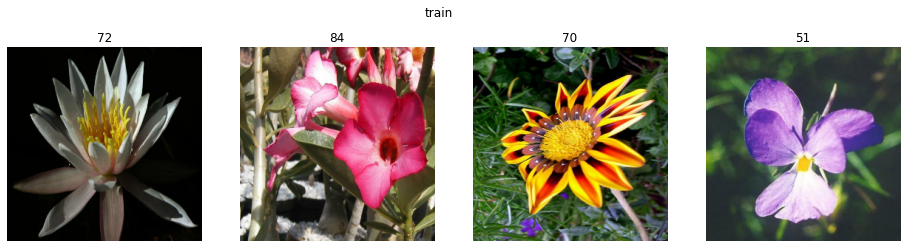

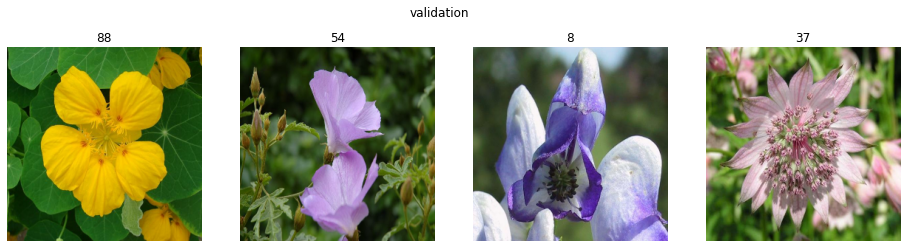

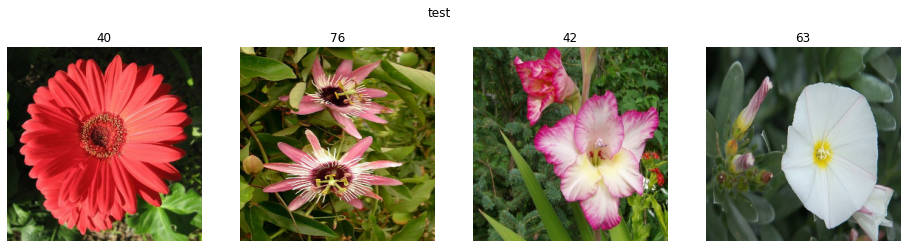

In [4]:
def plot_dataset(ds, count=4, title='dataset'):
    size = 4
    cols = 4
    rows = int((count+cols-1) / cols)

    ds_itr = ds.as_numpy_iterator()
    fig = plt.figure(figsize=(size*cols, size*rows))
    items = map(lambda id: (id,) + ds_itr.next(), range(count))

    for id, image, label in items:
        colid = id % cols
        rowid = id / cols

        ax = fig.add_subplot(rows, cols, id+1)

        ax.set_title(label)
        ax.imshow(image)
        ax.axis("off")
  
    fig.suptitle(title)
    plt.show()

plot_dataset(train_ds, title='train')
plot_dataset(val_ds, title='validation')
plot_dataset(test_ds, title='test')

#### Model Architecture

Here, we define two functions *create_model()* and *build_hp_model()*. The *create_model()* function creates a keras model based on the input hyperparameters. The *build_hp_model()* is a callback used by the tuner. It calls the *create_model()* function with the chosen hyperparameter values.

In [5]:
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002
NUM_CLASSES = 102

def build_hp_model(hp):
    if hp:
        learning_rate = hp.Float(
            "learning_rate",
            min_value=1e-4,
            max_value=1e-2,
            sampling="log"
        )
        dropout_rate = hp.Float(
            "dropout_rate",
            min_value=.1,
            max_value=.8,
            step=.1
        )

    return create_model(learning_rate, dropout_rate)

def create_model(learning_rate=LEARNING_RATE, dropout_rate=DROPOUT_RATE):
    # Initalize the core model
    core_args = dict(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
    core = apps.resnet50.ResNet50(**core_args)
    core.trainable = False

    # Setup the top
    model = tf.keras.Sequential([
        layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8),
        layers.Lambda(lambda x: tf.cast(x, tf.float32)),
        layers.Lambda(lambda x: apps.resnet.preprocess_input(x)),
        core,
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    adam = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# model = create_model()
model = build_hp_model(kt.HyperParameters())
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 264, 264, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 264, 264, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 9, 9, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 165888)            0         
_________________________________________________________________
dropout (Dropout)            (None, 165888)            0         
_________________________________________________________________
dense (Dense)                (None, 102)               16920678  
Total params: 40,508,390
Trainable params: 16,920,678
Non

### Hyperband Tuner

We initialize the hyperband tuner with basic configurations. The *factor* parameter decides the fraction of runs that progress to the next iteration. We choose a *factor* of 3 which means *1/3* of the runs in each bracket get to progress to the next iteration. The *objective* parameter chooses the metric to optimize. We are looking for the model with best validation accuracy. *max_epochs* is the maximum number of training epochs for a trial.

#### Initialize the tuner

In [6]:
tuner = kt.Hyperband(
    hypermodel=build_hp_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,
    overwrite=True,
    directory="hpo",
    project_name="hyperband",
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.1, 'sampling': None}


#### Run the tuner

In [7]:
tds = train_ds.batch(32)
vds = val_ds.batch(256)

tuner.search(tds, validation_data=vds)
tuner.results_summary()

Trial 30 Complete [00h 01m 24s]
val_accuracy: 0.6313725709915161

Best val_accuracy So Far: 0.7284313440322876
Total elapsed time: 00h 17m 23s
Results summary
Results in hpo/hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.00026592775384539827
dropout_rate: 0.7000000000000001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.7284313440322876
Trial summary
Hyperparameters:
learning_rate: 0.00026592775384539827
dropout_rate: 0.7000000000000001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7166666388511658
Trial summary
Hyperparameters:
learning_rate: 0.00017821013875888482
dropout_rate: 0.5
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7107843160629272
Trial summary
Hyperparameters:
learning_rate: 0.001055917932132645
dropout_rate: 0.7000000000000001
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 00

### Result Summary (Top 4)

| *dropout_rate* | *learning_rate*| *val_accuracy*| *epochs* |
|---|---|---|---|
|70%|0.000266|72.84%|10|
|70%|0.000266|71.67%|2|
|50%|0.000178|71.08%|4|
|70%|0.001056|70.49%|4|

In [8]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 264, 264, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 264, 264, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 9, 9, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 165888)            0         
_________________________________________________________________
dropout (Dropout)            (None, 165888)            0         
_________________________________________________________________
dense (Dense)                (None, 102)               16920678  
Total params: 40,508,390
Trainable params: 16,920,678
Non-trainable params: 23,587,712
___________________________________